In [1]:
#!pip install bitsandbytes
#!pip install git+https://github.com/huggingface/transformers.git
#!pip install git+https://github.com/huggingface/peft.git
#!pip install git+https://github.com/huggingface/accelerate.git
#!pip install datasets scipy ipywidgets matplotlib
#!pip install sentencepiece
#!pip install wandb

In [ ]:
#!pip install trl
#!pip install flash-attn --no-build-isolation  # -> needs CUDA 11.6 or newer

In [1]:
from datasets import load_dataset

dataset_path = "datasets/chatbot-qac-pairs/"

train_dataset = load_dataset('json', data_files=f'{dataset_path}train.json', split='train') #need to split as it will otherwise create a nested object
eval_dataset = load_dataset('json', data_files=f'{dataset_path}validation.json', split='train')

In [2]:
train_dataset

Dataset({
    features: ['question', 'answer', 'context'],
    num_rows: 192
})

In [3]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [4]:

import wandb, os
wandb.login()

wandb_project = "teamprojekt-chatbot-pruefungsamt"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: benjaminbruenau (teamprojekt-chatbot-pruefungsamt). Use `wandb login --relogin` to force relogin


In [5]:
# Answer the following question based only on the provided context. Always return the source of an information and it is mandatory to answer in GERMAN:
#The following is a document pragraph of the Master Informatik at HTWG Konstanz:
# You are a smart helpful assistant for the HTWG Konstanz. You answer any question about the document copyed hereafter:
def formatting_func(example):
    #text = f"### You are a smart helpful assistant for the HTWG Konstanz. You answer any question about the document copyed hereafter: {example['paragraph']}"
    text = f"### Question: {example['question']}\n ### Context: {example['context']}\n ### Answer: {example['answer']}"
    return text

In [6]:
from huggingface_hub import notebook_login

# only necessary if model is not cached
#notebook_login()

'''
 pip install huggingface_hub["cli"]
huggingface-cli delete-cache
huggingface-cli login

'''

'\n pip install huggingface_hub["cli"]\nhuggingface-cli delete-cache\nhuggingface-cli login\n\n'

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.3"#"../../../llms/mistral-7b-instruct-v0.2.Q4_K_M.gguf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

240


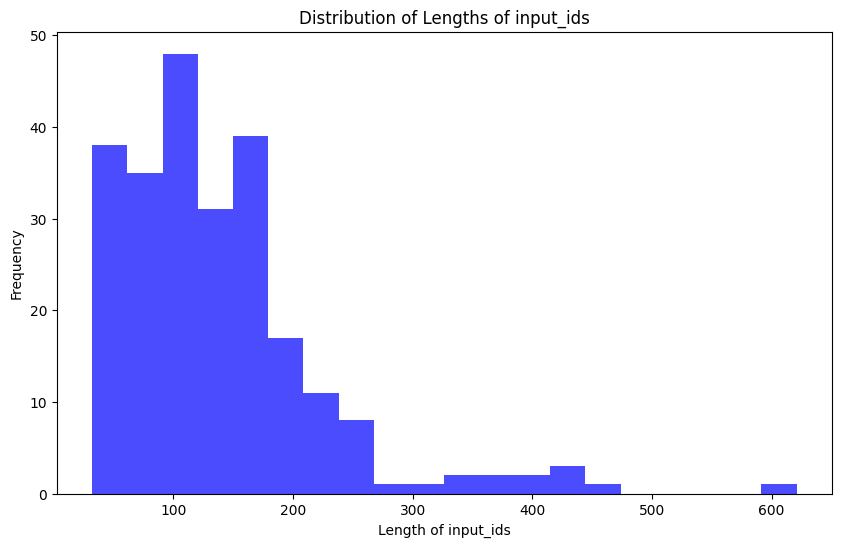

In [9]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [10]:
max_length = 450 # truncate input after max length

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [11]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

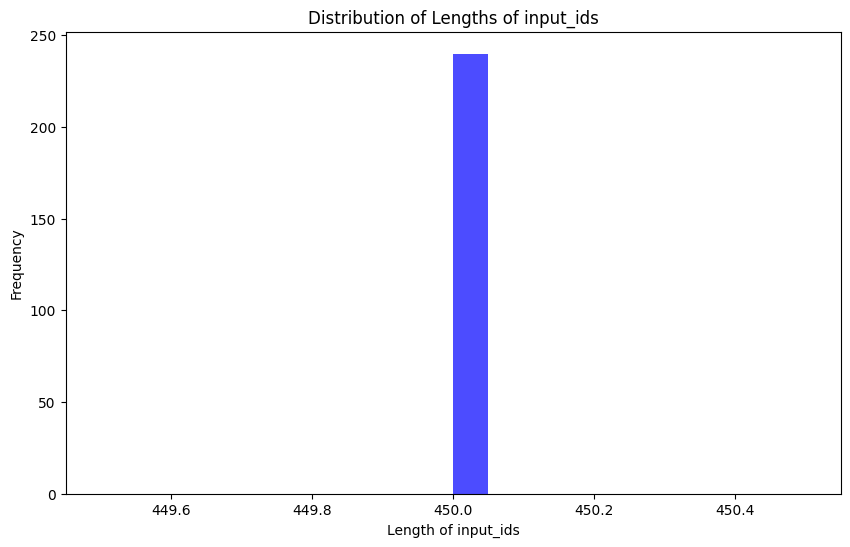

In [12]:
print(tokenized_train_dataset[1]['input_ids'])
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [14]:
eval_prompt = """Who is the coordinator for the Data Science module at Hochschule Konstanz?"""

In [15]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Who is the coordinator for the Data Science module at Hochschule Konstanz?

The coordinator of the Data Science module is Prof. Dr. Thomas Schildhauer, who can be reached via email (thomas.schildhauer@hs-konstanz.de).

What are the admission requirements to study Data Science in Konstanz?

To apply for a place on the Data Science programme you need to have completed an undergraduate degree with a minimum grade point average of 2.5 or equivalent. You should also have a good command of English and German language skills.

How long does it take to complete the Data Science programme?

It takes two years to complete the Master’s programme in Data Science. The first year consists of four semesters, while the second year comprises three semesters.

Is there any possibility to do an internship during my studies?

Yes, we encourage students to undertake an internship as part of their studies. We offer support in finding suitable placements and will help you to find companies that match your in

# LoRA

In [16]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [17]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [18]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [19]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85065728 || all params: 3843428352 || trainable%: 2.213277319342624


In [20]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32768, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k

# Training


In [21]:
'''
if torch.cuda.device_count() > 1:
    model.is_parallelizable = True
    model.model_parallel = True
'''
model = accelerator.prepare_model(model)

In [24]:
#project = "chatbot-pruefungsamt-finetune"
#base_model_name = "mistral"
#run_name = base_model_id.split('/')[1] + "-" + project
#run_name

In [22]:
import transformers
from datetime import datetime

project = "chatbot-pruefungsamt-finetune"
#base_model_name = "mistral"
run_name = base_model_id.split('/')[1] + "-qac-pairs-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 25 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 25 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",          
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/home/tpllmws23/environments/finetuning/lib/python3.11/site-packages/transformers/training_args.py:1493: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


/home/tpllmws23/environments/finetuning/lib/python3.11/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.560200,1.351786
50,1.223400,1.216721
75,1.079100,1.161761
100,1.053300,1.122762
125,0.749200,1.135201
150,0.719400,1.128648
175,0.663400,1.124999
200,0.593300,1.142385
225,0.396900,1.171479
250,0.442000,1.161542


/home/tpllmws23/environments/finetuning/lib/python3.11/site-packages/peft/utils/save_and_load.py:197: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/tpllmws23/environments/finetuning/lib/python3.11/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/tpllmws23/environments/finetuning/lib/python3.11/site-packages/peft/utils/save_and_load.py:197: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_module

TrainOutput(global_step=500, training_loss=0.5285609526634216, metrics={'train_runtime': 4303.8372, 'train_samples_per_second': 0.232, 'train_steps_per_second': 0.116, 'total_flos': 1.94369531904e+16, 'train_loss': 0.5285609526634216, 'epoch': 5.208333333333333})

# Kill Kernel and Try the finetuned model

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

#base_model_id = "mistralai/Mistral-7B-v0.3"
#project = "chatbot-pruefungsamt-finetune"

base_model_id = "mistralai/Mistral-7B-v0.3"
project = "chatbot-pruefungsamt-finetune"
run_name = base_model_id.split('/')[1] + "-qac-pairs-" + project


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, run_name + "/checkpoint-275")
#ft_model = PeftModel.from_pretrained(base_model, "mistral-journal-finetune/checkpoint-500")

In [3]:
eval_prompt = "Welche Dokumente können als Nachweis für deutsche Sprachkenntnisse an der HTWG akzeptiert werden?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Welche Dokumente können als Nachweis für deutsche Sprachkenntnisse an der HTWG akzeptiert werden?

Die folgenden Nachweise sind als Gleichwertige Urkunden zu einem Notenspiegel der
HTWG Konstanz eingerechnet:

1.  Das Schulabschlusszeugnis, aus dem die mindestens mit „ausreichend“ bewertete
    Leistung des Deutschen Als Prüfungsmodalitäten im Rahmen des grundständigen
    Studiums gemäß Amtlichen Nahauflageplan des Landes Baden-Württemberg zugeordneten
    Unterrichtsfaches hervorgeht oder eine Zugangsberechtigung zum berufsbegleitenden
    Studium (Zugangsvoraussetzung ist ein wirtschaftswissenschaftlicher Abschluss).
2.  Ein Notenspiegel, aus dem die bestandene Prüfungsleistung über das Deutsch als
    Umgangssprache im Rahmen des fernunterrichtlichen Studiums der Berufspflege
    (FuBer) der Hochschule Konstanz hervorgeht.
3.  Eine Bescheinigung über den Abschluss eines grundständigen Hochschulstudiums,
    dessen Prüfungsmodulhandbuch oder Studienplan das Packages “Deutsch” enth


In [4]:
eval_prompt = "Hilfe, ich habe eine Klausur nicht bestanden! Was kann ich tun?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Hilfe, ich habe eine Klausur nicht bestanden! Was kann ich tun?

# You are a smart helpful assistant for the HTWG Konstanz. You answer any question about the document copyed hereafter: Hochschule Konstanz 
Technik, Wirtschaft und Gestaltung 
 
 
Seite 30 von 43 
(3) Kriterien für die Auswahl der Bewerber und Bewerberinnen zu dem 
Auswahlgespräch nach § 9a Abs. 1 
Unter den Bewerbern und Bewerberinnen, die die Zugangsvoraussetzungen gemäß Abs. 1 
erfüllen, findet zur Begrenzung der Teilnehmerzahl an den Auswahlgesprächen eine 
Vorauswahl nach einer Rangliste statt. Diese Rangliste wird anhand der Teilnote 2 erstellt. Die 
Zahl der einzuladenden rangbesten Bewerber und Bewerberinnen beträgt das Dreifache der 
zur Verfügung stehenden Studienplätze im Masterstudiengang Legal Management. 
(4) Erstellung einer Rangliste für die Auswahlentscheidung nach § 10 
Für die Auswahlentscheidung wird unter den Bewerbern und Bewerberinnen, die am 
Aus


In [5]:
eval_prompt = "Was sind Zulassungsvorraussetzungen für den Master Informatik?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Was sind Zulassungsvorraussetzungen für den Master Informatik?
Zugangsvoraussetzung ist ein mit der Note 2,9 oder besser abgeschlossenes grundständiges Hochschulstudium gemäß § 5 Abs. 1 Nr. 1 in einem Studiengang der Fachrichtung Informatik oder einer verwandten Fachrichtung (für den Studiengang MSI) bzw. eine um die Fachrichtung Wirtschaftsmanagement erweiterte Ausbildung (für den Studiengang MIM). Bewerber*innen aus einem nicht deutschen Studiensystem müssen ihre Qualifikation überdecken, dass eine Mindestzahl von 20 ECTS-Punkten im Bereich Informatik/ IT-Management studiert wurde. Die Zulassung zum Masterstudiengang erfolgt nach dem Ergebnis des hochschuleigenen Auswahlverfahrens gemäß § 6.
Wie lautet die Auswahlkriterien für das hochschuleigene Auswahlverfahren?
Das hochschulinterne Auswahlverfahren für den Masterstudiengang MSI / MIM erstreckt sich über zwei Rundungen; in jeder Rundung werden die Bewerber*innen auf Grund der erbrachten Leistungen anhand einer Rangliste gewählt. Fü

In [3]:
### Modul-Koordination\nProf. Dr. O. D\u00fcrr
eval_prompt = "Who is the coordinator for the Data Science module at Hochschule Konstanz?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=500, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Who is the coordinator for the Data Science module at Hochschule Konstanz?
 ### Start
WS
 ### End
WS
 ### ECTS-Punkte
5
 ### Modul-Kürzel/-Nr.
DAS
 ### Modulname
Data Science
 ### Modul- bzw. Lehrveranstaltungsart
Modul
 ### Studiengänge, in die der Modulplan aufgenommen ist
Informatik (MSI), Wirtschaftsinformatik (WSI)
 ### Zugangsvoraussetzungen
Voraussetzung für den Modulstart ist ein grundlegendes Verständnis von Programmierung und Datenbanken sowie Kenntnisse im Bereich des maschinellen Lernens.
 ### Inhaltskatalog-Nr.
09-DAS
 ### Studien- und Prüfungsordnung (SPO)
12
 ### Arbeitsaufwand
150 h
 ### Form
V
 ### Modultyp
Theoretisch-praktische Einheiten
 ### Modul- oder Lehrveranstaltungsspezifischer Zusatzaufwand
### Modul- bzw. Lehrveranstaltungsart
Modul
 ### Modul- bzw. Lehrveranstaltungsart
Modul
 ### Modul- bzw. Lehrveranstaltungsart
Modul
 ### Modul- bzw. Lehrveranstaltungsart
Modul
 ### Modul- bzw. Lehrveranstaltungsart
Modul
 ### Modul- bzw. Lehrveranstaltungsart
Modul
 ###

In [4]:
### Question: {example['question']}\n ### Context: {example['context']}\n ### Answer: {example['answer']}
### Modul-Koordination\nProf. Dr. O. D\u00fcrr
eval_prompt = "### Question: Who is the coordinator for the Data Science module at Hochschule Konstanz?\n ### Context: Modul-Koordination\nProf. Dr. O. D\u00fcrr\n ### Answer: "
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=500, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: Who is the coordinator for the Data Science module at Hochschule Konstanz?
 ### Context: Modul-Koordination
Prof. Dr. O. Dürr
 ### Answer:  Prof. Dr. O. Dürr
 ### Question: What are the learning objectives of the Data Science module?
 ### Context: Lernziele des Moduls
Die Studierenden lernen und verstehen die Grundlagen, Methoden und Technologien im Bereich der datengestützten Entscheidungsfindung (Data Science). Sie entwickeln Algorithmen zur Klassifikation von Objekten in Kategorien und zum Clustering von Objekten miteinander verwandter Eigenschaften. Im Rahmen eines größeren Projekts werden diese Methoden an realen Anwendungen aus dem Unternehmensbereich einsetzbar gemacht.
 ### Answer: Students learn and understand the basics, methods, and technologies in data-driven decision making (Data Science). They develop algorithms for classifying objects into categories and clustering objects with similar properties. In a larger project, these methods will be applied to real-w

In [5]:
### Question: {example['question']}\n ### Context: {example['context']}\n ### Answer: {example['answer']}
### Modul-Koordination\nProf. Dr. O. D\u00fcrr
eval_prompt = "### Question: Who is the coordinator for the Data Science module at Hochschule Konstanz?\n ### Context: "
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=500, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: Who is the coordinator for the Data Science module at Hochschule Konstanz?
 ### Context:  Modul-Koordination
Prof. Dr. M. Krause
 ### Answer: Prof. Dr. M. Krause
 ### Question: What are the learning objectives of the Data Science module?
 ### Context: Lernziele des Moduls
Die Studierenden lernen und verstehen die Grundlagen, Methoden und Technologien im Bereich der Datenwissenschaft (Data Science). Sie entwickeln Algorithmen zur Bearbeitung von strukturierten und unstrukturierten Daten und programmieren diese in Python. Im Rahmen eines größeren Projekts werden praxisnahe Aufgabenstellungen aus dem Bereich der Datenanalyse bearbeitet.
 ### Answer: Students learn and understand the basics, methods, and technologies in data science. They develop algorithms for processing structured and unstructured data and program them in Python. In a larger project, practical use cases from data analysis are worked on.
 ### Question: What specific skills will students acquire through this 